<a href="https://colab.research.google.com/github/Codehackerone/GNN_Basics/blob/main/GNN_with_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pytorch geometric

In [11]:
!pip install --no-index torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cpu.html
!pip install --no-index torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cpu.html
!pip install --no-index torch-cluster -f https://pytorch-geometric.com/whl/torch-1.7.0+cpu.html
!pip install --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.7.0+cpu.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0+cpu.html
     |████████████████████████████████| 309 kB 35.1 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0+cpu.html
     |████████████████████████████████| 615 kB 31.6 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0+cpu.html
     |████████████████████████████████| 435 kB 16.1 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0+cpu.html
     |████████████████████████████████| 135 kB 29.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
from torch_geometric.data import Data

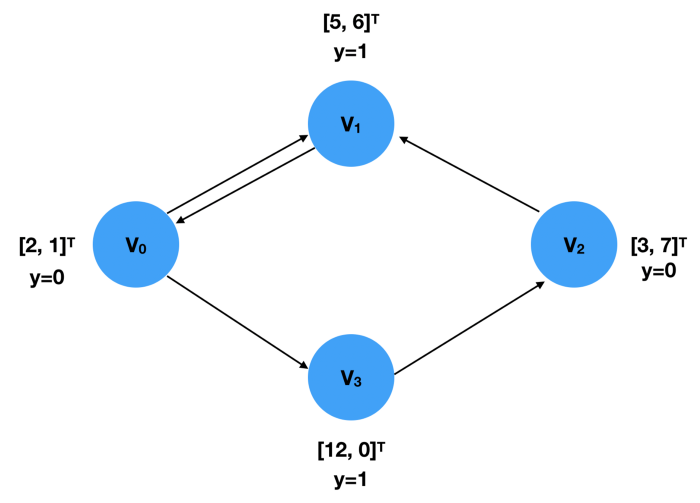

In [2]:
x = torch.tensor([[2,1], [5,6], [3,7], [12,0]], dtype=torch.float)
y = torch.tensor([0, 1, 0, 1], dtype=torch.float)

In [3]:
# Edge Index
edge_index = torch.tensor([[0, 1, 2, 0, 3],
                           [1, 0, 1, 3, 2]], dtype=torch.long)

In [ ]:
data = Data(x=x, y=y, edge_index=edge_index)

In [ ]:
# SageCOnv Layer
import torch
from torch.nn import Sequential as Seq, Linear, ReLU
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops
class SAGEConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(SAGEConv, self).__init__(aggr='max') #  "Max" aggregation.
        self.lin = torch.nn.Linear(in_channels, out_channels)
        self.act = torch.nn.ReLU()
        self.update_lin = torch.nn.Linear(in_channels + out_channels, in_channels, bias=False)
        self.update_act = torch.nn.ReLU()
        
    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]
        
        
        edge_index, _ = remove_self_loops(edge_index)
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        
        
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x)

    def message(self, x_j):
        # x_j has shape [E, in_channels]

        x_j = self.lin(x_j)
        x_j = self.act(x_j)
        
        return x_j

    def update(self, aggr_out, x):
        # aggr_out has shape [N, out_channels]


        new_embedding = torch.cat([aggr_out, x], dim=1)
        
        new_embedding = self.update_lin(new_embedding)
        new_embedding = self.update_act(new_embedding)
        
        return new_embedding

##  RecSys Challenge 2015 
Data - https://2015.recsyschallenge.com/challenge.html

In [ ]:
import pandas as pd

In [ ]:
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('../input/yoochoose-click.dat', header=None)
df.columns=['session_id','timestamp','item_id','category']

buy_df = pd.read_csv('../input/yoochoose-buys.dat', header=None)
buy_df.columns=['session_id','timestamp','item_id','price','quantity']

item_encoder = LabelEncoder()
df['item_id'] = item_encoder.fit_transform(df.item_id)
df.head()

In [ ]:
#randomly sample a couple of them
sampled_session_id = np.random.choice(df.session_id.unique(), 1000000, replace=False)
df = df.loc[df.session_id.isin(sampled_session_id)]
df.nunique()

In [ ]:
df['label'] = df.session_id.isin(buy_df.session_id)
df.head()

In [ ]:
# Dataset COnstruction
import torch
from torch_geometric.data import InMemoryDataset
from tqdm import tqdm

class YooChooseBinaryDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(YooChooseBinaryDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []
    @property
    def processed_file_names(self):
        return ['../input/yoochoose_click_binary_1M_sess.dataset']

    def download(self):
        pass
    
    def process(self):
        
        data_list = []

        # process by session_id
        grouped = df.groupby('session_id')
        for session_id, group in tqdm(grouped):
            sess_item_id = LabelEncoder().fit_transform(group.item_id)
            group = group.reset_index(drop=True)
            group['sess_item_id'] = sess_item_id
            node_features = group.loc[group.session_id==session_id,['sess_item_id','item_id']].sort_values('sess_item_id').item_id.drop_duplicates().values

            node_features = torch.LongTensor(node_features).unsqueeze(1)
            target_nodes = group.sess_item_id.values[1:]
            source_nodes = group.sess_item_id.values[:-1]

            edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)
            x = node_features

            y = torch.FloatTensor([group.label.values[0]])

            data = Data(x=x, edge_index=edge_index, y=y)
            data_list.append(data)
        
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])
        

In [ ]:
# Shuffling and Splitting
dataset = dataset.shuffle()
train_dataset = dataset[:800000]
val_dataset = dataset[800000:900000]
test_dataset = dataset[900000:]
len(train_dataset), len(val_dataset), len(test_dataset)

In [ ]:
# GNN Custom Model, SageConv instead of GCN
embed_dim = 128
from torch_geometric.nn import TopKPooling
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
import torch.nn.functional as F
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = SAGEConv(embed_dim, 128)
        self.pool1 = TopKPooling(128, ratio=0.8)
        self.conv2 = SAGEConv(128, 128)
        self.pool2 = TopKPooling(128, ratio=0.8)
        self.conv3 = SAGEConv(128, 128)
        self.pool3 = TopKPooling(128, ratio=0.8)
        self.item_embedding = torch.nn.Embedding(num_embeddings=df.item_id.max() +1, embedding_dim=embed_dim)
        self.lin1 = torch.nn.Linear(256, 128)
        self.lin2 = torch.nn.Linear(128, 64)
        self.lin3 = torch.nn.Linear(64, 1)
        self.bn1 = torch.nn.BatchNorm1d(128)
        self.bn2 = torch.nn.BatchNorm1d(64)
        self.act1 = torch.nn.ReLU()
        self.act2 = torch.nn.ReLU()        
  
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.item_embedding(x)
        x = x.squeeze(1)        

        x = F.relu(self.conv1(x, edge_index))

        x, edge_index, _, batch, _ = self.pool1(x, edge_index, None, batch)
        x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv2(x, edge_index))
     
        x, edge_index, _, batch, _ = self.pool2(x, edge_index, None, batch)
        x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv3(x, edge_index))

        x, edge_index, _, batch, _ = self.pool3(x, edge_index, None, batch)
        x3 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = x1 + x2 + x3

        x = self.lin1(x)
        x = self.act1(x)
        x = self.lin2(x)
        x = self.act2(x)      
        x = F.dropout(x, p=0.5, training=self.training)

        x = torch.sigmoid(self.lin3(x)).squeeze(1)

        return x

In [ ]:
# Train
def train():
    model.train()

    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        label = data.y.to(device)
        loss = crit(output, label)
        loss.backward()
        loss_all += data.num_graphs * loss.item()
        optimizer.step()
    return loss_all / len(train_dataset)
    
device = torch.device('cuda')
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
crit = torch.nn.BCELoss()
train_loader = DataLoader(train_dataset, batch_size=batch_size)
for epoch in range(num_epochs):
    train()
  

In [ ]:
# Validation
def evaluate(loader):
    model.eval()

    predictions = []
    labels = []

    with torch.no_grad():
        for data in loader:

            data = data.to(device)
            pred = model(data).detach().cpu().numpy()

            label = data.y.detach().cpu().numpy()
            predictions.append(pred)
            labels.append(label)

In [ ]:
# Actual Training

for epoch in range(1):
    loss = train()
    train_acc = evaluate(train_loader)
    val_acc = evaluate(val_loader)    
    test_acc = evaluate(test_loader)
    print('Epoch: {:03d}, Loss: {:.5f}, Train Auc: {:.5f}, Val Auc: {:.5f}, Test Auc: {:.5f}'.
          format(epoch, loss, train_acc, val_acc, test_acc))